In [42]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
SEED = 1234
NUM_SAMPLES = 100

In [44]:
torch.manual_seed(SEED)

In [45]:
def generate_data(NUM_SAMPLES):
    X = np.array(range(NUM_SAMPLES))
    noise = np.random.uniform(-10,20,NUM_SAMPLES)
    y = 3.5*X + noise
    return X,y

In [46]:
X,y = generate_data(NUM_SAMPLES)

In [47]:
# np.vstack([X,y])    ## 2x100
data = np.vstack([X,y]).T

In [48]:
data[:5]

array([[ 0.        , 13.04435519],
       [ 1.        ,  4.91744071],
       [ 2.        , 25.70349251],
       [ 3.        , 17.28326034],
       [ 4.        , 30.50527966]])

In [49]:
df = pd.DataFrame(data,columns=['X','y'])

In [50]:
df.head()

,X,y
0,0.0,13.044355
1,1.0,4.917441
2,2.0,25.703493
3,3.0,17.283260
4,4.0,30.505280


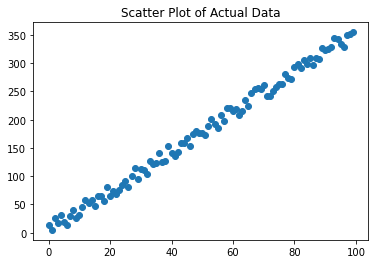

In [51]:
plt.title('Scatter Plot of Actual Data')
plt.scatter(x=df['X'],y=df['y'])
plt.show()

In [54]:
X = X.reshape((100,1))
y = y.reshape((100,1))

In [55]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [56]:
indices = list(range(NUM_SAMPLES))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [57]:
TRAIN_START = 0
TRAIN_END = int(TRAIN_SIZE*NUM_SAMPLES)
VAL_START = TRAIN_END
VAL_END = int((TRAIN_SIZE+VAL_SIZE)*NUM_SAMPLES)
TEST_START = VAL_END
TEST_END = NUM_SAMPLES

In [58]:
X_train = X[TRAIN_START:TRAIN_END]
y_train = y[TRAIN_START:TRAIN_END]
X_val = X[VAL_START:VAL_END]
y_val = y[VAL_START:VAL_END]
X_test = X[TEST_START:TEST_END]
y_test = y[TEST_START:TEST_END]

In [59]:
def standardize_data(data, mean, std):
    return (data - mean)/std

In [60]:
X_mean = np.mean(X_train)
X_std = np.std(X_train)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

In [61]:
X_train = standardize_data(X_train, X_mean, X_std)
y_train = standardize_data(y_train, y_mean, y_std)
X_val = standardize_data(X_val, X_mean, X_std)
y_val = standardize_data(y_val, y_mean, y_std)
X_test = standardize_data(X_test, X_mean, X_std)
y_test = standardize_data(y_test, y_mean, y_std)

## Pytorch Walkthrough

In [63]:
INPUT_DIM = X.shape[1]
OUTPUT_DIM = y.shape[1]

In [64]:
from torch import nn

In [65]:
# Weights
m = nn.Linear(INPUT_DIM, OUTPUT_DIM)
print (m)
print (f"weights ({m.weight.shape}): {m.weight[0][0]}")
print (f"bias ({m.bias.shape}): {m.bias[0]}")

Linear(in_features=1, out_features=1, bias=True)
weights (torch.Size([1, 1])): -0.9420415163040161
bias (torch.Size([1])): -0.19620287418365479


In [68]:
# Inputs
N = 3 # num samples
x = torch.randn(N, INPUT_DIM)
print (x.shape)
print (x.numpy())
print("-----------")
# Output
z = m(x)
print (z.shape)
print (z.detach().numpy())

torch.Size([3, 1])
[[ 0.5098422 ]
 [-0.08205455]
 [ 0.6607317 ]]
-----------
torch.Size([3, 1])
[[-0.67649543]
 [-0.11890408]
 [-0.8186395 ]]


## Model

In [69]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)

    def forward(self, x_in):
        y_pred = self.fc1(x_in)
        return y_pred

In [70]:
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
print (model.named_parameters)

<bound method Module.named_parameters of LinearRegression(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)>


In [74]:
loss_fn = nn.MSELoss()

In [73]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [75]:
from torch.optim import Adam
NUM_EPOCHS = 100
LEARNING_RATE = 1e-1
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [76]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0:
        print (f"Epoch: {epoch} | loss: {loss:.2f}")

Epoch: 0 | loss: 2.21
Epoch: 20 | loss: 0.04
Epoch: 40 | loss: 0.01
Epoch: 60 | loss: 0.01
Epoch: 80 | loss: 0.01


In [77]:

# Predictions
pred_train = model(X_train)
pred_test = model(X_test)

In [78]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f"train_error: {train_error:.2f}")
print(f"test_error: {test_error:.2f}")

train_error: 0.01
test_error: 0.01


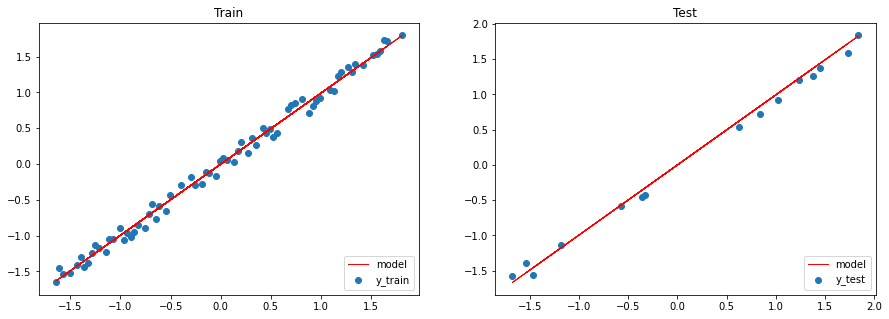

In [79]:

# Figure size
plt.figure(figsize=(15,5))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label="y_train")
plt.plot(X_train, pred_train.detach().numpy(), color="red", linewidth=1, linestyle="-", label="model")
plt.legend(loc="lower right")

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label='y_test')
plt.plot(X_test, pred_test.detach().numpy(), color="red", linewidth=1, linestyle="-", label="model")
plt.legend(loc="lower right")

# Show plots
plt.show()

In [89]:
# Unstandardize coefficients
W = model.fc1.weight.data.numpy()[0][0]
b = model.fc1.bias.data.numpy()[0]

In [90]:
W_unscaled = W * (y_std/X_std)
b_unscaled = b * y_std + y_mean - np.sum(W_unscaled*X_mean)

In [96]:
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled:.3} X + {b_unscaled:.3f}")

[actual] y = 3.5X + noise
[model] y_hat = 3.54 X + 3.355
